## Advisory 
### If you have not yet begun the project 
Please do not use this workspace.  Use the AWS resources provided and the instructions from the [cloud computing lesson](https://classroom.udacity.com/nanodegrees/nd101/parts/b9c4c3c3-b524-427b-8832-9d0748f14a2e/modules/de12f7bf-d980-4998-ab91-0e411184c878/lessons/29df00d8-01c2-4995-92fa-a4afd020be90/concepts/80d2ed46-1bba-413e-891e-610259017251).
### If you have started on this workspace
Please consider downloading your Jupyter notebook and then following the instructions above on using AWS instead.  You can upload your current work to AWS through your GitHub account.  


As a reminder, the project can be found on the [deep learning GitHub page](https://github.com/udacity/deep-learning/tree/master/face_generation).
These warnings are given because the project frequently generates more data than the workspace can handle, causing loading problems and lost work.  Please use [the forums](https://discussions.udacity.com/c/nd101-part-5-GANs/nd101-generate-faces) if you have any questions on the project or its setup.


# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


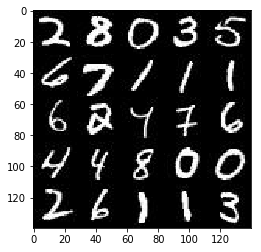

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

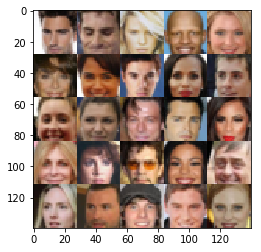

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), 'real_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), 'z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [25]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # 1st layer 28 x 28 x 64
        x1 = tf.layers.conv2d(images, 64, 5, 2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        
        # 2nd layer 14 x 14 x 128
        x2 = tf.layers.conv2d(x1, 128, 5, 2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        # Flatten the second layer
        x2 = tf.reshape(x2, (-1, 7*7*128))
        
        # 3d layer
        logits = tf.layers.dense(x2, 1)
        output = tf.sigmoid(logits)
        
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [26]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # 1st layer 7 x 7 x 128
        x1 = tf.layers.dense(z, 7*7*128)
        x1 = tf.reshape(x1, (-1, 7, 7, 128))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        # 2nd layer 14 x 14 x 128
        x2 = tf.layers.conv2d_transpose(x1, 64, 5, 2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        # 3d layer 28 x 28 x out_channel_dim
        x3 = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, 2, padding='same')
        x3 = tf.tanh(x3)

        return x3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [16]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    generator_output = generator(input_z, out_channel_dim)
    
    output_real, logits_real = discriminator(input_real)
    output_fake, logits_fake = discriminator(generator_output, reuse=True)
    
    d_loss_real = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real, labels=tf.ones_like(logits_real) * 0.9)
    d_loss_real = tf.reduce_mean(d_loss_real)
    
    d_loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.zeros_like(logits_fake))
    d_loss_fake = tf.reduce_mean(d_loss_fake)
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.ones_like(logits_fake))
    g_loss = tf.reduce_mean(g_loss)
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [17]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    trainable_vars = tf.trainable_variables()
    generator_vars = [var for var in trainable_vars if var.name.startswith('generator')]
    discriminator_vars = [var for var in trainable_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_optimizer = tf.train.AdamOptimizer(beta1=beta1).minimize(d_loss, var_list=discriminator_vars)
        g_optimizer = tf.train.AdamOptimizer(beta1=beta1).minimize(g_loss, var_list=generator_vars)
    
    return d_optimizer, g_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [28]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Image size and color channels
    img_width, img_height, img_channels = data_shape[1:4]
    
    # Model inputs
    real_input, z_input, l_rate = model_inputs(img_width, img_height, img_channels, z_dim)
    
    # Loss functions
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    
    # Optimizers
    d_optimizer, g_optimizer = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Saver
    saver = tf.train.Saver()
    
    # Counter
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Generate noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_optimizer, feed_dict={real_input: batch_images, 
                                                     z_input: batch_z, 
                                                     l_rate: learning_rate})
                _ = sess.run(g_optimizer, feed_dict={real_input: batch_images,
                                                     z_input: batch_z,
                                                     l_rate: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({real_input: batch_images, z_input: batch_z})
                    train_loss_g = g_loss.eval({real_input: batch_images, z_input: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 16, z_input, img_channels, data_image_mode)
        
        saver.save(sess, './checkpoints/generator.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/10... Discriminator Loss: 1.0328... Generator Loss: 1.0389
Epoch 1/10... Discriminator Loss: 1.4835... Generator Loss: 2.2170
Epoch 1/10... Discriminator Loss: 0.9913... Generator Loss: 1.7214
Epoch 1/10... Discriminator Loss: 1.0551... Generator Loss: 0.9808
Epoch 1/10... Discriminator Loss: 1.0116... Generator Loss: 2.4801
Epoch 1/10... Discriminator Loss: 1.0083... Generator Loss: 0.8104
Epoch 1/10... Discriminator Loss: 1.0255... Generator Loss: 4.3613
Epoch 1/10... Discriminator Loss: 1.6576... Generator Loss: 0.3481
Epoch 1/10... Discriminator Loss: 1.2211... Generator Loss: 0.6343
Epoch 1/10... Discriminator Loss: 0.5876... Generator Loss: 1.8438


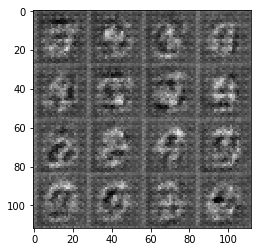

Epoch 1/10... Discriminator Loss: 1.5299... Generator Loss: 0.4445
Epoch 1/10... Discriminator Loss: 1.1576... Generator Loss: 1.0444
Epoch 1/10... Discriminator Loss: 0.8827... Generator Loss: 1.2259
Epoch 1/10... Discriminator Loss: 0.9289... Generator Loss: 1.0175
Epoch 1/10... Discriminator Loss: 0.8498... Generator Loss: 1.4193
Epoch 1/10... Discriminator Loss: 1.1132... Generator Loss: 2.1014
Epoch 1/10... Discriminator Loss: 0.8423... Generator Loss: 1.8533
Epoch 1/10... Discriminator Loss: 0.7083... Generator Loss: 1.4260
Epoch 1/10... Discriminator Loss: 0.9362... Generator Loss: 0.9203
Epoch 1/10... Discriminator Loss: 0.7073... Generator Loss: 2.0903


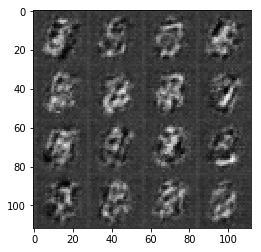

Epoch 1/10... Discriminator Loss: 1.3176... Generator Loss: 3.1838
Epoch 1/10... Discriminator Loss: 0.7445... Generator Loss: 1.4949
Epoch 1/10... Discriminator Loss: 0.6884... Generator Loss: 2.3661
Epoch 1/10... Discriminator Loss: 1.0077... Generator Loss: 2.8346
Epoch 1/10... Discriminator Loss: 0.6782... Generator Loss: 2.3814
Epoch 1/10... Discriminator Loss: 0.9544... Generator Loss: 2.9605
Epoch 1/10... Discriminator Loss: 0.9204... Generator Loss: 1.2259
Epoch 1/10... Discriminator Loss: 0.6943... Generator Loss: 1.3784
Epoch 1/10... Discriminator Loss: 0.7273... Generator Loss: 2.0322
Epoch 1/10... Discriminator Loss: 0.7094... Generator Loss: 1.3131


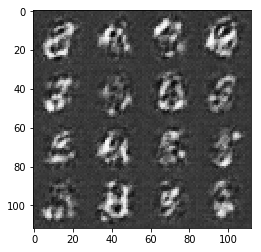

Epoch 1/10... Discriminator Loss: 0.8874... Generator Loss: 0.9702
Epoch 1/10... Discriminator Loss: 0.9123... Generator Loss: 1.4219
Epoch 1/10... Discriminator Loss: 0.6643... Generator Loss: 1.7198
Epoch 1/10... Discriminator Loss: 0.5677... Generator Loss: 1.9518
Epoch 1/10... Discriminator Loss: 0.5208... Generator Loss: 2.2165
Epoch 1/10... Discriminator Loss: 0.4861... Generator Loss: 2.1587
Epoch 1/10... Discriminator Loss: 2.2688... Generator Loss: 0.2496
Epoch 1/10... Discriminator Loss: 0.6463... Generator Loss: 2.1163
Epoch 1/10... Discriminator Loss: 0.5571... Generator Loss: 2.0104
Epoch 1/10... Discriminator Loss: 0.4873... Generator Loss: 2.4272


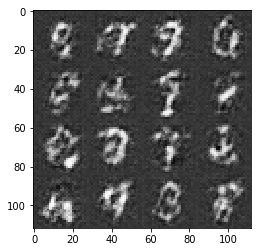

Epoch 1/10... Discriminator Loss: 0.4604... Generator Loss: 2.7685
Epoch 1/10... Discriminator Loss: 0.4680... Generator Loss: 2.3229
Epoch 1/10... Discriminator Loss: 0.4696... Generator Loss: 2.3076
Epoch 1/10... Discriminator Loss: 1.3787... Generator Loss: 0.6392
Epoch 1/10... Discriminator Loss: 0.6355... Generator Loss: 1.8493
Epoch 1/10... Discriminator Loss: 0.5896... Generator Loss: 2.2208
Epoch 2/10... Discriminator Loss: 0.5737... Generator Loss: 1.7475
Epoch 2/10... Discriminator Loss: 0.5106... Generator Loss: 2.0722
Epoch 2/10... Discriminator Loss: 0.4439... Generator Loss: 2.6533
Epoch 2/10... Discriminator Loss: 0.4383... Generator Loss: 2.7477


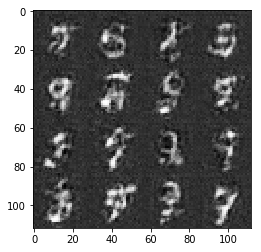

Epoch 2/10... Discriminator Loss: 0.4168... Generator Loss: 2.9606
Epoch 2/10... Discriminator Loss: 0.4056... Generator Loss: 3.2538
Epoch 2/10... Discriminator Loss: 0.4213... Generator Loss: 3.8264
Epoch 2/10... Discriminator Loss: 0.3965... Generator Loss: 3.8468
Epoch 2/10... Discriminator Loss: 1.3497... Generator Loss: 0.6357
Epoch 2/10... Discriminator Loss: 0.6402... Generator Loss: 2.3791
Epoch 2/10... Discriminator Loss: 0.7038... Generator Loss: 1.3711
Epoch 2/10... Discriminator Loss: 0.5523... Generator Loss: 2.0172
Epoch 2/10... Discriminator Loss: 0.4656... Generator Loss: 2.6901
Epoch 2/10... Discriminator Loss: 0.4436... Generator Loss: 2.8884


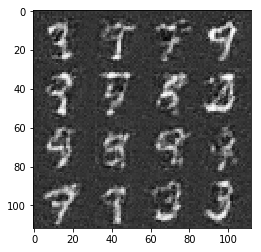

Epoch 2/10... Discriminator Loss: 0.4680... Generator Loss: 2.3787
Epoch 2/10... Discriminator Loss: 0.4428... Generator Loss: 2.6188
Epoch 2/10... Discriminator Loss: 0.4859... Generator Loss: 2.1800
Epoch 2/10... Discriminator Loss: 0.9584... Generator Loss: 1.0116
Epoch 2/10... Discriminator Loss: 0.5300... Generator Loss: 2.2012
Epoch 2/10... Discriminator Loss: 0.4630... Generator Loss: 2.6013
Epoch 2/10... Discriminator Loss: 0.4232... Generator Loss: 3.1542
Epoch 2/10... Discriminator Loss: 0.4513... Generator Loss: 2.4752
Epoch 2/10... Discriminator Loss: 0.4591... Generator Loss: 2.4284
Epoch 2/10... Discriminator Loss: 1.0844... Generator Loss: 0.8132


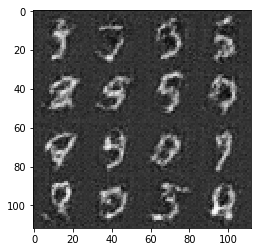

Epoch 2/10... Discriminator Loss: 1.5921... Generator Loss: 3.8913
Epoch 2/10... Discriminator Loss: 1.1034... Generator Loss: 3.6946
Epoch 2/10... Discriminator Loss: 0.8504... Generator Loss: 1.1290
Epoch 2/10... Discriminator Loss: 1.1442... Generator Loss: 0.7345
Epoch 2/10... Discriminator Loss: 0.6204... Generator Loss: 1.6454
Epoch 2/10... Discriminator Loss: 0.5187... Generator Loss: 2.1938
Epoch 2/10... Discriminator Loss: 0.8234... Generator Loss: 3.3146
Epoch 2/10... Discriminator Loss: 0.8389... Generator Loss: 1.3850
Epoch 2/10... Discriminator Loss: 1.0870... Generator Loss: 0.7507
Epoch 2/10... Discriminator Loss: 0.6153... Generator Loss: 1.6497


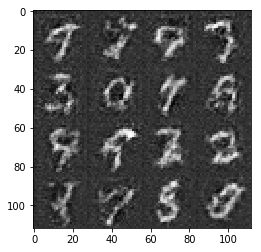

Epoch 2/10... Discriminator Loss: 0.5427... Generator Loss: 2.1384
Epoch 2/10... Discriminator Loss: 0.5197... Generator Loss: 2.0553
Epoch 2/10... Discriminator Loss: 0.5877... Generator Loss: 1.6869
Epoch 2/10... Discriminator Loss: 0.4875... Generator Loss: 2.5912
Epoch 2/10... Discriminator Loss: 0.5220... Generator Loss: 2.6687
Epoch 2/10... Discriminator Loss: 1.1403... Generator Loss: 0.8763
Epoch 2/10... Discriminator Loss: 0.5913... Generator Loss: 2.1448
Epoch 2/10... Discriminator Loss: 0.6859... Generator Loss: 1.3959
Epoch 2/10... Discriminator Loss: 0.5794... Generator Loss: 1.8507
Epoch 2/10... Discriminator Loss: 0.4941... Generator Loss: 2.6633


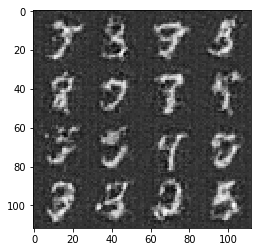

Epoch 2/10... Discriminator Loss: 0.5012... Generator Loss: 2.1549
Epoch 2/10... Discriminator Loss: 0.4525... Generator Loss: 2.7011
Epoch 2/10... Discriminator Loss: 0.4579... Generator Loss: 2.7203
Epoch 3/10... Discriminator Loss: 0.4323... Generator Loss: 2.7493
Epoch 3/10... Discriminator Loss: 0.4353... Generator Loss: 2.9294
Epoch 3/10... Discriminator Loss: 0.4931... Generator Loss: 2.2932
Epoch 3/10... Discriminator Loss: 1.7374... Generator Loss: 4.0197
Epoch 3/10... Discriminator Loss: 0.8568... Generator Loss: 3.2742
Epoch 3/10... Discriminator Loss: 0.7448... Generator Loss: 1.2729
Epoch 3/10... Discriminator Loss: 0.5502... Generator Loss: 1.9852


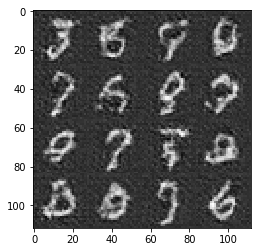

Epoch 3/10... Discriminator Loss: 0.5081... Generator Loss: 2.2833
Epoch 3/10... Discriminator Loss: 0.4748... Generator Loss: 2.6359
Epoch 3/10... Discriminator Loss: 0.4979... Generator Loss: 3.1406
Epoch 3/10... Discriminator Loss: 0.4372... Generator Loss: 3.1184
Epoch 3/10... Discriminator Loss: 0.9888... Generator Loss: 3.6726
Epoch 3/10... Discriminator Loss: 0.6677... Generator Loss: 1.7425
Epoch 3/10... Discriminator Loss: 0.5381... Generator Loss: 1.9919
Epoch 3/10... Discriminator Loss: 0.4958... Generator Loss: 2.4534
Epoch 3/10... Discriminator Loss: 0.4436... Generator Loss: 2.7781
Epoch 3/10... Discriminator Loss: 0.4508... Generator Loss: 2.5897


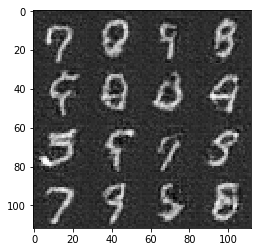

Epoch 3/10... Discriminator Loss: 0.4020... Generator Loss: 3.3693
Epoch 3/10... Discriminator Loss: 0.4207... Generator Loss: 2.8782
Epoch 3/10... Discriminator Loss: 0.4883... Generator Loss: 2.2075
Epoch 3/10... Discriminator Loss: 3.5695... Generator Loss: 6.0012
Epoch 3/10... Discriminator Loss: 1.0448... Generator Loss: 3.0494
Epoch 3/10... Discriminator Loss: 0.7496... Generator Loss: 2.0384
Epoch 3/10... Discriminator Loss: 0.6429... Generator Loss: 2.1608
Epoch 3/10... Discriminator Loss: 0.5895... Generator Loss: 2.3571
Epoch 3/10... Discriminator Loss: 0.8257... Generator Loss: 1.0838
Epoch 3/10... Discriminator Loss: 0.5196... Generator Loss: 2.2727


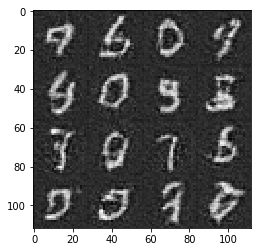

Epoch 3/10... Discriminator Loss: 0.5083... Generator Loss: 2.2121
Epoch 3/10... Discriminator Loss: 0.4235... Generator Loss: 2.9096
Epoch 3/10... Discriminator Loss: 0.4772... Generator Loss: 2.3017
Epoch 3/10... Discriminator Loss: 0.5083... Generator Loss: 2.0964
Epoch 3/10... Discriminator Loss: 0.9386... Generator Loss: 3.0599
Epoch 3/10... Discriminator Loss: 0.7643... Generator Loss: 2.4986
Epoch 3/10... Discriminator Loss: 0.6549... Generator Loss: 1.5029
Epoch 3/10... Discriminator Loss: 0.5763... Generator Loss: 2.6027
Epoch 3/10... Discriminator Loss: 0.5667... Generator Loss: 1.9341
Epoch 3/10... Discriminator Loss: 0.7513... Generator Loss: 1.2567


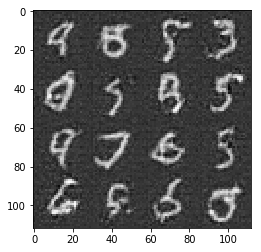

Epoch 3/10... Discriminator Loss: 0.9543... Generator Loss: 3.7566
Epoch 3/10... Discriminator Loss: 0.5761... Generator Loss: 2.1981
Epoch 3/10... Discriminator Loss: 0.5349... Generator Loss: 2.0453
Epoch 3/10... Discriminator Loss: 0.4956... Generator Loss: 2.4933
Epoch 3/10... Discriminator Loss: 0.4533... Generator Loss: 2.6437
Epoch 3/10... Discriminator Loss: 0.4547... Generator Loss: 2.8012
Epoch 3/10... Discriminator Loss: 0.4117... Generator Loss: 3.1303
Epoch 3/10... Discriminator Loss: 0.4242... Generator Loss: 3.2236
Epoch 3/10... Discriminator Loss: 0.4240... Generator Loss: 2.7753
Epoch 3/10... Discriminator Loss: 0.3744... Generator Loss: 4.2230


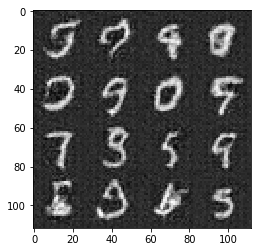

Epoch 4/10... Discriminator Loss: 0.4532... Generator Loss: 2.5617
Epoch 4/10... Discriminator Loss: 0.4341... Generator Loss: 2.7822
Epoch 4/10... Discriminator Loss: 0.3950... Generator Loss: 3.5437
Epoch 4/10... Discriminator Loss: 2.4842... Generator Loss: 3.2775
Epoch 4/10... Discriminator Loss: 0.9267... Generator Loss: 1.7910
Epoch 4/10... Discriminator Loss: 1.0622... Generator Loss: 0.9305
Epoch 4/10... Discriminator Loss: 1.2174... Generator Loss: 0.6750
Epoch 4/10... Discriminator Loss: 0.5541... Generator Loss: 2.1710
Epoch 4/10... Discriminator Loss: 1.0610... Generator Loss: 3.3167
Epoch 4/10... Discriminator Loss: 0.5602... Generator Loss: 2.3445


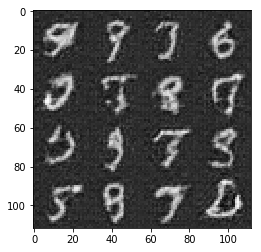

Epoch 4/10... Discriminator Loss: 0.5427... Generator Loss: 2.4319
Epoch 4/10... Discriminator Loss: 0.5232... Generator Loss: 2.1680
Epoch 4/10... Discriminator Loss: 0.4608... Generator Loss: 2.8718
Epoch 4/10... Discriminator Loss: 0.4431... Generator Loss: 2.8679
Epoch 4/10... Discriminator Loss: 0.4414... Generator Loss: 3.0070
Epoch 4/10... Discriminator Loss: 0.4426... Generator Loss: 2.6798
Epoch 4/10... Discriminator Loss: 0.4379... Generator Loss: 2.8258
Epoch 4/10... Discriminator Loss: 0.4485... Generator Loss: 2.5443
Epoch 4/10... Discriminator Loss: 0.5026... Generator Loss: 2.2076
Epoch 4/10... Discriminator Loss: 0.3899... Generator Loss: 3.9338


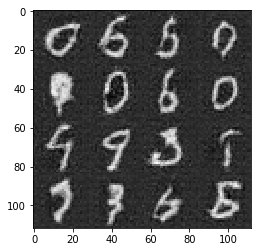

Epoch 4/10... Discriminator Loss: 0.3876... Generator Loss: 3.5039
Epoch 4/10... Discriminator Loss: 0.4628... Generator Loss: 2.5355
Epoch 4/10... Discriminator Loss: 0.4568... Generator Loss: 2.5590
Epoch 4/10... Discriminator Loss: 0.4345... Generator Loss: 3.7125
Epoch 4/10... Discriminator Loss: 0.4204... Generator Loss: 3.0388
Epoch 4/10... Discriminator Loss: 0.8201... Generator Loss: 1.2381
Epoch 4/10... Discriminator Loss: 1.0269... Generator Loss: 1.4358
Epoch 4/10... Discriminator Loss: 0.7223... Generator Loss: 2.0028
Epoch 4/10... Discriminator Loss: 0.6935... Generator Loss: 3.2947
Epoch 4/10... Discriminator Loss: 0.8311... Generator Loss: 3.3765


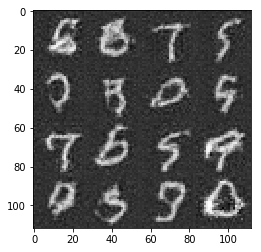

Epoch 4/10... Discriminator Loss: 1.2046... Generator Loss: 0.7776
Epoch 4/10... Discriminator Loss: 0.5869... Generator Loss: 2.1893
Epoch 4/10... Discriminator Loss: 0.4882... Generator Loss: 2.6106
Epoch 4/10... Discriminator Loss: 0.4818... Generator Loss: 2.6790
Epoch 4/10... Discriminator Loss: 0.4528... Generator Loss: 2.8127
Epoch 4/10... Discriminator Loss: 0.5004... Generator Loss: 2.8324
Epoch 4/10... Discriminator Loss: 0.5282... Generator Loss: 2.0755
Epoch 4/10... Discriminator Loss: 0.4160... Generator Loss: 3.2011
Epoch 4/10... Discriminator Loss: 0.4768... Generator Loss: 2.4059
Epoch 4/10... Discriminator Loss: 0.4428... Generator Loss: 2.6872


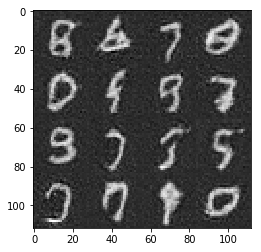

Epoch 4/10... Discriminator Loss: 0.4389... Generator Loss: 2.6412
Epoch 4/10... Discriminator Loss: 0.5188... Generator Loss: 2.1172
Epoch 4/10... Discriminator Loss: 0.4545... Generator Loss: 2.6529
Epoch 4/10... Discriminator Loss: 0.4310... Generator Loss: 3.4733
Epoch 4/10... Discriminator Loss: 0.4399... Generator Loss: 3.6012
Epoch 4/10... Discriminator Loss: 0.8282... Generator Loss: 1.2090
Epoch 4/10... Discriminator Loss: 0.9346... Generator Loss: 1.4522
Epoch 5/10... Discriminator Loss: 1.0940... Generator Loss: 0.8603
Epoch 5/10... Discriminator Loss: 1.4576... Generator Loss: 0.5382
Epoch 5/10... Discriminator Loss: 0.7194... Generator Loss: 1.4146


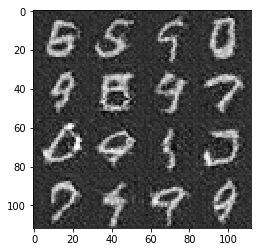

Epoch 5/10... Discriminator Loss: 0.9367... Generator Loss: 0.9920
Epoch 5/10... Discriminator Loss: 0.5978... Generator Loss: 2.2554
Epoch 5/10... Discriminator Loss: 0.5262... Generator Loss: 3.0981
Epoch 5/10... Discriminator Loss: 0.4357... Generator Loss: 2.8216
Epoch 5/10... Discriminator Loss: 0.4275... Generator Loss: 2.8147
Epoch 5/10... Discriminator Loss: 0.4411... Generator Loss: 2.8560
Epoch 5/10... Discriminator Loss: 0.4676... Generator Loss: 2.7869
Epoch 5/10... Discriminator Loss: 0.4577... Generator Loss: 2.6037
Epoch 5/10... Discriminator Loss: 0.4595... Generator Loss: 2.5240
Epoch 5/10... Discriminator Loss: 0.4153... Generator Loss: 3.1071


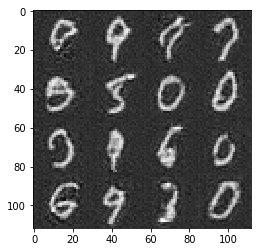

Epoch 5/10... Discriminator Loss: 0.3995... Generator Loss: 3.4380
Epoch 5/10... Discriminator Loss: 0.3945... Generator Loss: 3.2646
Epoch 5/10... Discriminator Loss: 0.5002... Generator Loss: 2.6716
Epoch 5/10... Discriminator Loss: 0.4131... Generator Loss: 3.1223
Epoch 5/10... Discriminator Loss: 0.9158... Generator Loss: 2.0780
Epoch 5/10... Discriminator Loss: 1.0769... Generator Loss: 0.9035
Epoch 5/10... Discriminator Loss: 0.5851... Generator Loss: 2.3893
Epoch 5/10... Discriminator Loss: 0.5477... Generator Loss: 2.2816
Epoch 5/10... Discriminator Loss: 0.5671... Generator Loss: 1.8639
Epoch 5/10... Discriminator Loss: 0.5425... Generator Loss: 2.2095


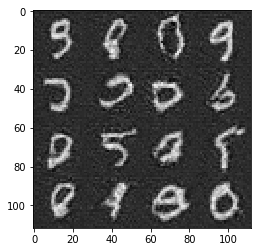

Epoch 5/10... Discriminator Loss: 0.6328... Generator Loss: 2.9699
Epoch 5/10... Discriminator Loss: 1.9528... Generator Loss: 4.9911
Epoch 5/10... Discriminator Loss: 0.5918... Generator Loss: 2.0578
Epoch 5/10... Discriminator Loss: 0.7522... Generator Loss: 1.3496
Epoch 5/10... Discriminator Loss: 0.7253... Generator Loss: 1.3404
Epoch 5/10... Discriminator Loss: 0.6970... Generator Loss: 1.4097
Epoch 5/10... Discriminator Loss: 0.5004... Generator Loss: 2.4923
Epoch 5/10... Discriminator Loss: 1.6726... Generator Loss: 4.3073
Epoch 5/10... Discriminator Loss: 0.6483... Generator Loss: 2.5998
Epoch 5/10... Discriminator Loss: 0.6144... Generator Loss: 1.7200


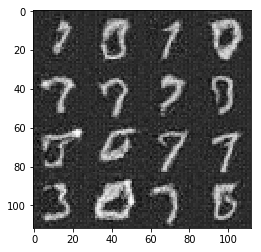

Epoch 5/10... Discriminator Loss: 0.5472... Generator Loss: 2.3062
Epoch 5/10... Discriminator Loss: 0.5146... Generator Loss: 2.4666
Epoch 5/10... Discriminator Loss: 0.4875... Generator Loss: 2.4826
Epoch 5/10... Discriminator Loss: 0.4714... Generator Loss: 2.6370
Epoch 5/10... Discriminator Loss: 0.5733... Generator Loss: 2.8069
Epoch 5/10... Discriminator Loss: 0.9195... Generator Loss: 1.0260
Epoch 5/10... Discriminator Loss: 0.8291... Generator Loss: 2.4626
Epoch 5/10... Discriminator Loss: 0.6536... Generator Loss: 1.7325
Epoch 5/10... Discriminator Loss: 0.6418... Generator Loss: 1.6502
Epoch 5/10... Discriminator Loss: 0.6416... Generator Loss: 1.5363


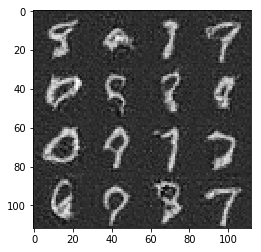

Epoch 5/10... Discriminator Loss: 0.4855... Generator Loss: 2.5774
Epoch 5/10... Discriminator Loss: 0.4988... Generator Loss: 2.2518
Epoch 5/10... Discriminator Loss: 0.4861... Generator Loss: 2.3457
Epoch 5/10... Discriminator Loss: 0.4549... Generator Loss: 2.6260
Epoch 6/10... Discriminator Loss: 0.4092... Generator Loss: 3.7696
Epoch 6/10... Discriminator Loss: 0.4010... Generator Loss: 3.3201
Epoch 6/10... Discriminator Loss: 0.4613... Generator Loss: 3.2677
Epoch 6/10... Discriminator Loss: 1.0328... Generator Loss: 1.2035
Epoch 6/10... Discriminator Loss: 0.5989... Generator Loss: 2.3120
Epoch 6/10... Discriminator Loss: 0.6274... Generator Loss: 1.7646


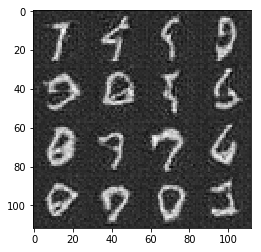

Epoch 6/10... Discriminator Loss: 0.6416... Generator Loss: 2.4120
Epoch 6/10... Discriminator Loss: 0.6176... Generator Loss: 1.6564
Epoch 6/10... Discriminator Loss: 0.5593... Generator Loss: 2.3026
Epoch 6/10... Discriminator Loss: 0.5798... Generator Loss: 1.8229
Epoch 6/10... Discriminator Loss: 0.5409... Generator Loss: 2.8149
Epoch 6/10... Discriminator Loss: 0.4598... Generator Loss: 2.6289
Epoch 6/10... Discriminator Loss: 0.4827... Generator Loss: 2.3192
Epoch 6/10... Discriminator Loss: 0.4939... Generator Loss: 2.3786
Epoch 6/10... Discriminator Loss: 0.4480... Generator Loss: 2.7052
Epoch 6/10... Discriminator Loss: 0.6280... Generator Loss: 1.6524


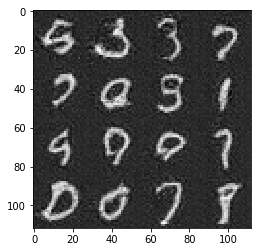

Epoch 6/10... Discriminator Loss: 0.4866... Generator Loss: 2.3266
Epoch 6/10... Discriminator Loss: 0.3854... Generator Loss: 3.6214
Epoch 6/10... Discriminator Loss: 0.4360... Generator Loss: 2.9661
Epoch 6/10... Discriminator Loss: 0.4220... Generator Loss: 3.0279
Epoch 6/10... Discriminator Loss: 0.4183... Generator Loss: 3.1769
Epoch 6/10... Discriminator Loss: 0.4359... Generator Loss: 2.8708
Epoch 6/10... Discriminator Loss: 0.4301... Generator Loss: 2.8874
Epoch 6/10... Discriminator Loss: 0.4555... Generator Loss: 2.5483
Epoch 6/10... Discriminator Loss: 0.4040... Generator Loss: 3.2831
Epoch 6/10... Discriminator Loss: 0.4157... Generator Loss: 3.0043


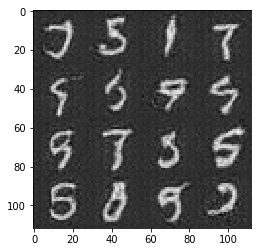

Epoch 6/10... Discriminator Loss: 0.4158... Generator Loss: 3.4687
Epoch 6/10... Discriminator Loss: 0.4067... Generator Loss: 3.4405
Epoch 6/10... Discriminator Loss: 0.4448... Generator Loss: 2.7989
Epoch 6/10... Discriminator Loss: 0.3833... Generator Loss: 3.9347
Epoch 6/10... Discriminator Loss: 0.3874... Generator Loss: 3.5817
Epoch 6/10... Discriminator Loss: 0.4140... Generator Loss: 3.1309
Epoch 6/10... Discriminator Loss: 0.4116... Generator Loss: 3.8543
Epoch 6/10... Discriminator Loss: 1.3868... Generator Loss: 4.5870
Epoch 6/10... Discriminator Loss: 0.6839... Generator Loss: 2.0758
Epoch 6/10... Discriminator Loss: 0.7069... Generator Loss: 1.5178


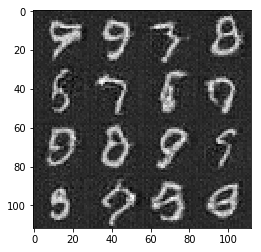

Epoch 6/10... Discriminator Loss: 0.6467... Generator Loss: 2.7964


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.00001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/10... Discriminator Loss: 0.5146... Generator Loss: 5.9011
Epoch 1/10... Discriminator Loss: 0.6086... Generator Loss: 2.5089
Epoch 1/10... Discriminator Loss: 0.4705... Generator Loss: 4.5863
Epoch 1/10... Discriminator Loss: 0.9152... Generator Loss: 6.8347
Epoch 1/10... Discriminator Loss: 0.5163... Generator Loss: 3.7233
Epoch 1/10... Discriminator Loss: 0.3995... Generator Loss: 3.5531
Epoch 1/10... Discriminator Loss: 0.3495... Generator Loss: 5.4393
Epoch 1/10... Discriminator Loss: 0.3740... Generator Loss: 3.7662
Epoch 1/10... Discriminator Loss: 0.3597... Generator Loss: 6.6618
Epoch 1/10... Discriminator Loss: 0.4030... Generator Loss: 3.1956


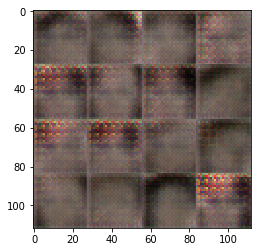

Epoch 1/10... Discriminator Loss: 0.6175... Generator Loss: 2.3449
Epoch 1/10... Discriminator Loss: 1.3883... Generator Loss: 0.7048
Epoch 1/10... Discriminator Loss: 0.4877... Generator Loss: 2.9861
Epoch 1/10... Discriminator Loss: 0.7452... Generator Loss: 1.4693
Epoch 1/10... Discriminator Loss: 0.6031... Generator Loss: 2.2235
Epoch 1/10... Discriminator Loss: 0.4307... Generator Loss: 7.6130
Epoch 1/10... Discriminator Loss: 0.5218... Generator Loss: 3.2087
Epoch 1/10... Discriminator Loss: 0.4924... Generator Loss: 2.6693
Epoch 1/10... Discriminator Loss: 0.6329... Generator Loss: 1.9642
Epoch 1/10... Discriminator Loss: 1.0026... Generator Loss: 0.9409


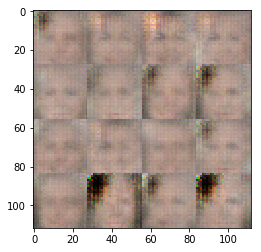

Epoch 1/10... Discriminator Loss: 0.6198... Generator Loss: 2.9794
Epoch 1/10... Discriminator Loss: 0.4928... Generator Loss: 2.7650
Epoch 1/10... Discriminator Loss: 0.7797... Generator Loss: 5.1042
Epoch 1/10... Discriminator Loss: 0.4928... Generator Loss: 4.3859
Epoch 1/10... Discriminator Loss: 0.6474... Generator Loss: 1.8046
Epoch 1/10... Discriminator Loss: 0.4500... Generator Loss: 4.7829
Epoch 1/10... Discriminator Loss: 0.5748... Generator Loss: 4.2646
Epoch 1/10... Discriminator Loss: 0.4470... Generator Loss: 5.5659
Epoch 1/10... Discriminator Loss: 1.0785... Generator Loss: 1.0937
Epoch 1/10... Discriminator Loss: 0.4608... Generator Loss: 4.0908


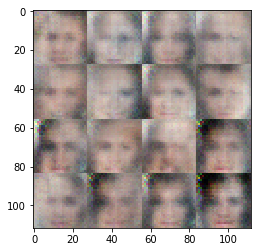

Epoch 1/10... Discriminator Loss: 0.4991... Generator Loss: 6.6787
Epoch 1/10... Discriminator Loss: 0.5094... Generator Loss: 3.0229
Epoch 1/10... Discriminator Loss: 0.5926... Generator Loss: 3.3317
Epoch 1/10... Discriminator Loss: 4.5105... Generator Loss: 4.0085
Epoch 1/10... Discriminator Loss: 0.6263... Generator Loss: 2.5988
Epoch 1/10... Discriminator Loss: 0.4299... Generator Loss: 3.3557
Epoch 1/10... Discriminator Loss: 0.6555... Generator Loss: 4.9846
Epoch 1/10... Discriminator Loss: 0.7101... Generator Loss: 1.5491
Epoch 1/10... Discriminator Loss: 1.6406... Generator Loss: 0.6636
Epoch 1/10... Discriminator Loss: 0.5471... Generator Loss: 7.5576


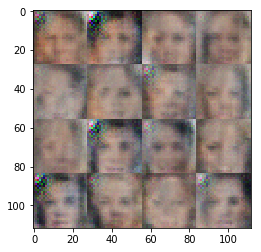

Epoch 1/10... Discriminator Loss: 0.5008... Generator Loss: 4.1524
Epoch 1/10... Discriminator Loss: 0.6096... Generator Loss: 4.6188
Epoch 1/10... Discriminator Loss: 0.6694... Generator Loss: 2.2868
Epoch 1/10... Discriminator Loss: 0.9420... Generator Loss: 7.8801
Epoch 1/10... Discriminator Loss: 0.4868... Generator Loss: 4.3850
Epoch 1/10... Discriminator Loss: 0.5538... Generator Loss: 3.5740
Epoch 1/10... Discriminator Loss: 0.6703... Generator Loss: 1.4697
Epoch 1/10... Discriminator Loss: 0.5213... Generator Loss: 3.6534
Epoch 1/10... Discriminator Loss: 0.5331... Generator Loss: 3.7309
Epoch 1/10... Discriminator Loss: 2.4911... Generator Loss: 0.3341


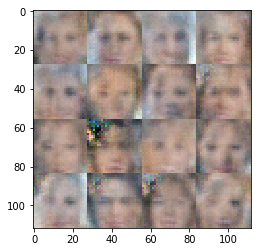

Epoch 1/10... Discriminator Loss: 1.8129... Generator Loss: 0.8035
Epoch 1/10... Discriminator Loss: 0.8874... Generator Loss: 2.2944
Epoch 1/10... Discriminator Loss: 0.8282... Generator Loss: 1.3322
Epoch 1/10... Discriminator Loss: 0.6138... Generator Loss: 2.0241
Epoch 1/10... Discriminator Loss: 0.7318... Generator Loss: 4.0525
Epoch 1/10... Discriminator Loss: 0.7393... Generator Loss: 1.4100
Epoch 1/10... Discriminator Loss: 0.5041... Generator Loss: 3.5228
Epoch 1/10... Discriminator Loss: 0.6295... Generator Loss: 2.2922
Epoch 1/10... Discriminator Loss: 0.5313... Generator Loss: 2.9685
Epoch 1/10... Discriminator Loss: 0.8963... Generator Loss: 1.0664


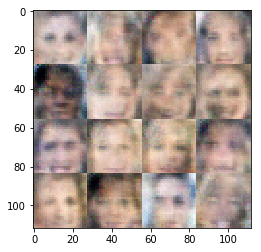

Epoch 1/10... Discriminator Loss: 0.5305... Generator Loss: 2.6512
Epoch 1/10... Discriminator Loss: 0.4141... Generator Loss: 8.5437
Epoch 1/10... Discriminator Loss: 0.7013... Generator Loss: 2.1603
Epoch 1/10... Discriminator Loss: 2.4039... Generator Loss: 0.7913
Epoch 1/10... Discriminator Loss: 0.9375... Generator Loss: 2.6741
Epoch 1/10... Discriminator Loss: 0.5488... Generator Loss: 4.7631
Epoch 1/10... Discriminator Loss: 0.7387... Generator Loss: 1.6878
Epoch 1/10... Discriminator Loss: 0.9719... Generator Loss: 1.0814
Epoch 1/10... Discriminator Loss: 0.6111... Generator Loss: 2.7933
Epoch 1/10... Discriminator Loss: 1.3313... Generator Loss: 5.5513


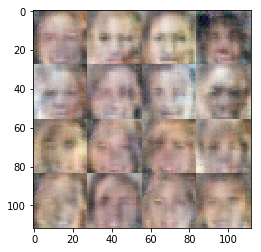

Epoch 1/10... Discriminator Loss: 2.2530... Generator Loss: 1.7073
Epoch 1/10... Discriminator Loss: 2.0157... Generator Loss: 0.3809
Epoch 1/10... Discriminator Loss: 0.7655... Generator Loss: 1.5371
Epoch 1/10... Discriminator Loss: 0.5313... Generator Loss: 5.8841
Epoch 1/10... Discriminator Loss: 0.9276... Generator Loss: 1.2633
Epoch 1/10... Discriminator Loss: 0.7651... Generator Loss: 5.3516
Epoch 1/10... Discriminator Loss: 1.0745... Generator Loss: 0.7952
Epoch 1/10... Discriminator Loss: 1.0007... Generator Loss: 1.0894
Epoch 1/10... Discriminator Loss: 0.5408... Generator Loss: 5.4110
Epoch 1/10... Discriminator Loss: 0.5192... Generator Loss: 3.9059


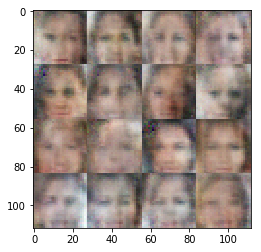

Epoch 1/10... Discriminator Loss: 2.6320... Generator Loss: 6.2356
Epoch 1/10... Discriminator Loss: 0.8353... Generator Loss: 1.7668
Epoch 1/10... Discriminator Loss: 1.5230... Generator Loss: 2.4054
Epoch 1/10... Discriminator Loss: 0.6604... Generator Loss: 2.0172
Epoch 1/10... Discriminator Loss: 0.6368... Generator Loss: 4.2033
Epoch 1/10... Discriminator Loss: 0.7003... Generator Loss: 1.7653
Epoch 1/10... Discriminator Loss: 0.9147... Generator Loss: 3.1347
Epoch 1/10... Discriminator Loss: 0.4900... Generator Loss: 3.5434
Epoch 1/10... Discriminator Loss: 0.6294... Generator Loss: 3.7336
Epoch 1/10... Discriminator Loss: 0.5774... Generator Loss: 3.1843


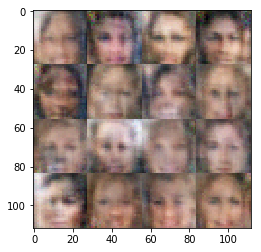

Epoch 1/10... Discriminator Loss: 0.6368... Generator Loss: 2.1175
Epoch 1/10... Discriminator Loss: 0.7457... Generator Loss: 2.6586
Epoch 1/10... Discriminator Loss: 1.4166... Generator Loss: 0.6201
Epoch 1/10... Discriminator Loss: 0.9691... Generator Loss: 1.1986
Epoch 1/10... Discriminator Loss: 0.7733... Generator Loss: 4.2988
Epoch 1/10... Discriminator Loss: 0.7819... Generator Loss: 1.3064
Epoch 1/10... Discriminator Loss: 0.6384... Generator Loss: 2.3998
Epoch 1/10... Discriminator Loss: 0.6687... Generator Loss: 2.0818
Epoch 1/10... Discriminator Loss: 0.4830... Generator Loss: 3.9220
Epoch 1/10... Discriminator Loss: 4.1238... Generator Loss: 3.1241


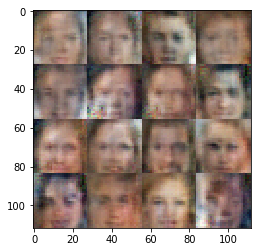

Epoch 1/10... Discriminator Loss: 0.5049... Generator Loss: 4.1066
Epoch 1/10... Discriminator Loss: 0.8047... Generator Loss: 2.3872
Epoch 1/10... Discriminator Loss: 0.6103... Generator Loss: 2.3953
Epoch 1/10... Discriminator Loss: 0.5799... Generator Loss: 3.9814
Epoch 1/10... Discriminator Loss: 0.8160... Generator Loss: 10.0612
Epoch 1/10... Discriminator Loss: 0.8243... Generator Loss: 1.2598
Epoch 1/10... Discriminator Loss: 0.4930... Generator Loss: 4.1579
Epoch 1/10... Discriminator Loss: 0.4521... Generator Loss: 4.3539
Epoch 1/10... Discriminator Loss: 1.1347... Generator Loss: 0.9246
Epoch 1/10... Discriminator Loss: 0.5273... Generator Loss: 3.2054


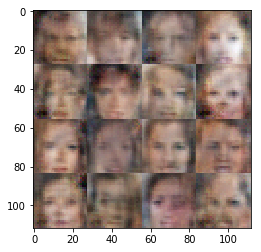

Epoch 1/10... Discriminator Loss: 0.6623... Generator Loss: 3.8898
Epoch 1/10... Discriminator Loss: 0.6376... Generator Loss: 3.8864
Epoch 1/10... Discriminator Loss: 0.9594... Generator Loss: 4.5326
Epoch 1/10... Discriminator Loss: 1.0802... Generator Loss: 7.4956
Epoch 1/10... Discriminator Loss: 0.4607... Generator Loss: 4.7445
Epoch 1/10... Discriminator Loss: 0.4155... Generator Loss: 4.6152
Epoch 1/10... Discriminator Loss: 1.7794... Generator Loss: 3.6673
Epoch 1/10... Discriminator Loss: 1.6058... Generator Loss: 2.4617
Epoch 1/10... Discriminator Loss: 0.8100... Generator Loss: 4.6455
Epoch 1/10... Discriminator Loss: 0.7019... Generator Loss: 3.3234


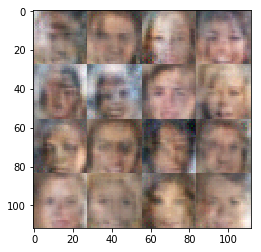

Epoch 1/10... Discriminator Loss: 0.6810... Generator Loss: 1.6838
Epoch 1/10... Discriminator Loss: 0.6130... Generator Loss: 2.4749
Epoch 1/10... Discriminator Loss: 0.5381... Generator Loss: 4.3374
Epoch 1/10... Discriminator Loss: 0.6708... Generator Loss: 2.4996
Epoch 1/10... Discriminator Loss: 3.6296... Generator Loss: 5.2695
Epoch 1/10... Discriminator Loss: 1.6797... Generator Loss: 4.7753
Epoch 1/10... Discriminator Loss: 1.3075... Generator Loss: 0.6291
Epoch 1/10... Discriminator Loss: 1.2623... Generator Loss: 7.0255
Epoch 1/10... Discriminator Loss: 1.4702... Generator Loss: 2.7780
Epoch 1/10... Discriminator Loss: 0.8489... Generator Loss: 1.3703


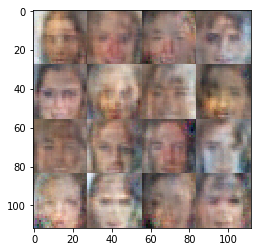

Epoch 1/10... Discriminator Loss: 0.8042... Generator Loss: 1.5994
Epoch 1/10... Discriminator Loss: 0.5611... Generator Loss: 2.3948
Epoch 1/10... Discriminator Loss: 0.9208... Generator Loss: 1.5853
Epoch 1/10... Discriminator Loss: 1.1306... Generator Loss: 2.1845
Epoch 1/10... Discriminator Loss: 0.7657... Generator Loss: 3.5293
Epoch 1/10... Discriminator Loss: 0.5131... Generator Loss: 4.7149
Epoch 1/10... Discriminator Loss: 0.6925... Generator Loss: 1.6013
Epoch 1/10... Discriminator Loss: 0.6504... Generator Loss: 2.6469
Epoch 1/10... Discriminator Loss: 0.6089... Generator Loss: 3.2872
Epoch 1/10... Discriminator Loss: 0.8041... Generator Loss: 1.4293


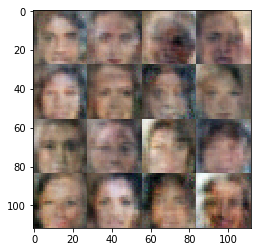

Epoch 1/10... Discriminator Loss: 1.3222... Generator Loss: 0.6674
Epoch 1/10... Discriminator Loss: 0.4924... Generator Loss: 3.8020
Epoch 1/10... Discriminator Loss: 0.6843... Generator Loss: 1.8863
Epoch 1/10... Discriminator Loss: 0.6342... Generator Loss: 2.1252
Epoch 1/10... Discriminator Loss: 0.5466... Generator Loss: 3.0453
Epoch 1/10... Discriminator Loss: 0.7693... Generator Loss: 5.4060
Epoch 1/10... Discriminator Loss: 0.5322... Generator Loss: 3.7868
Epoch 1/10... Discriminator Loss: 0.6756... Generator Loss: 6.4239
Epoch 1/10... Discriminator Loss: 0.5900... Generator Loss: 5.3832
Epoch 1/10... Discriminator Loss: 1.9068... Generator Loss: 0.3322


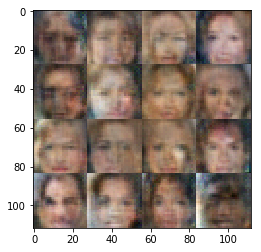

Epoch 1/10... Discriminator Loss: 0.7394... Generator Loss: 1.4323
Epoch 1/10... Discriminator Loss: 0.7679... Generator Loss: 1.4634
Epoch 1/10... Discriminator Loss: 0.7772... Generator Loss: 1.5143
Epoch 1/10... Discriminator Loss: 0.8015... Generator Loss: 1.3119
Epoch 1/10... Discriminator Loss: 0.7859... Generator Loss: 2.0113
Epoch 1/10... Discriminator Loss: 0.7906... Generator Loss: 1.7123
Epoch 1/10... Discriminator Loss: 1.6399... Generator Loss: 1.8458
Epoch 1/10... Discriminator Loss: 1.7655... Generator Loss: 3.5283
Epoch 2/10... Discriminator Loss: 0.5758... Generator Loss: 2.6765
Epoch 2/10... Discriminator Loss: 0.9489... Generator Loss: 0.9439


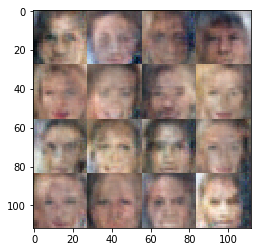

Epoch 2/10... Discriminator Loss: 0.7812... Generator Loss: 1.2891
Epoch 2/10... Discriminator Loss: 1.3980... Generator Loss: 1.0769
Epoch 2/10... Discriminator Loss: 0.7040... Generator Loss: 1.8256
Epoch 2/10... Discriminator Loss: 0.9866... Generator Loss: 1.1053
Epoch 2/10... Discriminator Loss: 0.5869... Generator Loss: 3.9863
Epoch 2/10... Discriminator Loss: 1.1406... Generator Loss: 3.5438
Epoch 2/10... Discriminator Loss: 1.5524... Generator Loss: 0.5276
Epoch 2/10... Discriminator Loss: 0.6110... Generator Loss: 2.0156
Epoch 2/10... Discriminator Loss: 0.9337... Generator Loss: 1.9969
Epoch 2/10... Discriminator Loss: 1.0513... Generator Loss: 0.8560


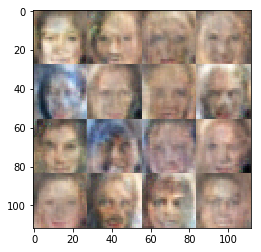

Epoch 2/10... Discriminator Loss: 1.1690... Generator Loss: 0.7165
Epoch 2/10... Discriminator Loss: 0.7365... Generator Loss: 1.6675
Epoch 2/10... Discriminator Loss: 0.7760... Generator Loss: 1.6285
Epoch 2/10... Discriminator Loss: 2.8042... Generator Loss: 0.4732
Epoch 2/10... Discriminator Loss: 0.7394... Generator Loss: 5.6028
Epoch 2/10... Discriminator Loss: 0.6381... Generator Loss: 2.2470
Epoch 2/10... Discriminator Loss: 0.7891... Generator Loss: 6.3381
Epoch 2/10... Discriminator Loss: 1.1317... Generator Loss: 1.7105
Epoch 2/10... Discriminator Loss: 0.9648... Generator Loss: 1.1336
Epoch 2/10... Discriminator Loss: 0.8484... Generator Loss: 1.3254


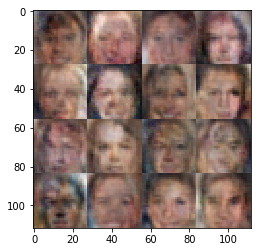

Epoch 2/10... Discriminator Loss: 0.8750... Generator Loss: 2.4305
Epoch 2/10... Discriminator Loss: 2.6061... Generator Loss: 0.7140
Epoch 2/10... Discriminator Loss: 0.8406... Generator Loss: 2.2304
Epoch 2/10... Discriminator Loss: 1.7031... Generator Loss: 0.3701
Epoch 2/10... Discriminator Loss: 1.4381... Generator Loss: 0.7264
Epoch 2/10... Discriminator Loss: 1.0266... Generator Loss: 0.9885
Epoch 2/10... Discriminator Loss: 0.7295... Generator Loss: 1.9020
Epoch 2/10... Discriminator Loss: 1.4295... Generator Loss: 2.4673
Epoch 2/10... Discriminator Loss: 0.9536... Generator Loss: 2.2213
Epoch 2/10... Discriminator Loss: 1.0725... Generator Loss: 0.8846


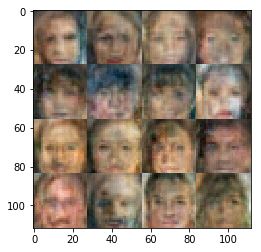

Epoch 2/10... Discriminator Loss: 1.0799... Generator Loss: 0.9975
Epoch 2/10... Discriminator Loss: 0.8039... Generator Loss: 1.5378
Epoch 2/10... Discriminator Loss: 1.0051... Generator Loss: 1.0273
Epoch 2/10... Discriminator Loss: 1.1921... Generator Loss: 1.4273
Epoch 2/10... Discriminator Loss: 0.7603... Generator Loss: 1.4282
Epoch 2/10... Discriminator Loss: 1.1078... Generator Loss: 3.4622
Epoch 2/10... Discriminator Loss: 1.4133... Generator Loss: 1.3264
Epoch 2/10... Discriminator Loss: 0.9689... Generator Loss: 1.2029
Epoch 2/10... Discriminator Loss: 1.0567... Generator Loss: 1.0622
Epoch 2/10... Discriminator Loss: 1.0849... Generator Loss: 3.2228


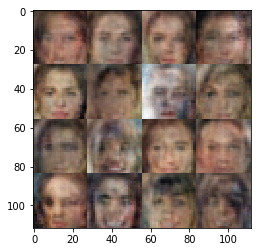

Epoch 2/10... Discriminator Loss: 1.0254... Generator Loss: 1.3390
Epoch 2/10... Discriminator Loss: 0.9281... Generator Loss: 1.2064
Epoch 2/10... Discriminator Loss: 1.2837... Generator Loss: 1.1455
Epoch 2/10... Discriminator Loss: 1.0525... Generator Loss: 1.1850
Epoch 2/10... Discriminator Loss: 1.1022... Generator Loss: 1.1297
Epoch 2/10... Discriminator Loss: 1.6833... Generator Loss: 2.9533
Epoch 2/10... Discriminator Loss: 1.0276... Generator Loss: 1.4820
Epoch 2/10... Discriminator Loss: 0.9148... Generator Loss: 1.3113
Epoch 2/10... Discriminator Loss: 1.0753... Generator Loss: 0.8299
Epoch 2/10... Discriminator Loss: 0.5511... Generator Loss: 3.1593


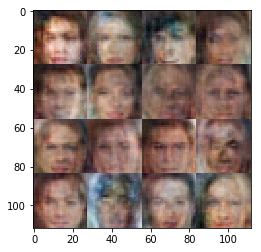

Epoch 2/10... Discriminator Loss: 0.9239... Generator Loss: 1.2203
Epoch 2/10... Discriminator Loss: 1.2630... Generator Loss: 0.6802
Epoch 2/10... Discriminator Loss: 0.8142... Generator Loss: 1.8708
Epoch 2/10... Discriminator Loss: 0.8867... Generator Loss: 1.6990
Epoch 2/10... Discriminator Loss: 0.6785... Generator Loss: 1.8832
Epoch 2/10... Discriminator Loss: 1.1808... Generator Loss: 2.0259
Epoch 2/10... Discriminator Loss: 1.2804... Generator Loss: 0.8571
Epoch 2/10... Discriminator Loss: 2.0730... Generator Loss: 1.1385
Epoch 2/10... Discriminator Loss: 1.2573... Generator Loss: 0.7552
Epoch 2/10... Discriminator Loss: 1.0953... Generator Loss: 1.1724


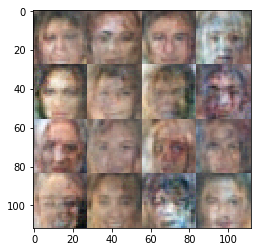

Epoch 2/10... Discriminator Loss: 1.6082... Generator Loss: 0.4424
Epoch 2/10... Discriminator Loss: 1.3263... Generator Loss: 1.1163
Epoch 2/10... Discriminator Loss: 1.3580... Generator Loss: 0.5783
Epoch 2/10... Discriminator Loss: 1.3632... Generator Loss: 0.9661
Epoch 2/10... Discriminator Loss: 1.3294... Generator Loss: 0.7871
Epoch 2/10... Discriminator Loss: 1.3981... Generator Loss: 0.7292
Epoch 2/10... Discriminator Loss: 1.2430... Generator Loss: 0.8109
Epoch 2/10... Discriminator Loss: 1.3535... Generator Loss: 0.7861
Epoch 2/10... Discriminator Loss: 1.3147... Generator Loss: 0.7348
Epoch 2/10... Discriminator Loss: 1.2566... Generator Loss: 1.0074


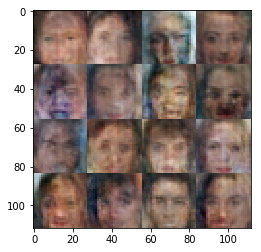

Epoch 2/10... Discriminator Loss: 1.3313... Generator Loss: 1.7437
Epoch 2/10... Discriminator Loss: 1.4861... Generator Loss: 0.5716
Epoch 2/10... Discriminator Loss: 1.2507... Generator Loss: 0.7127
Epoch 2/10... Discriminator Loss: 1.2402... Generator Loss: 1.0761
Epoch 2/10... Discriminator Loss: 1.2795... Generator Loss: 0.9267
Epoch 2/10... Discriminator Loss: 1.3960... Generator Loss: 0.5443
Epoch 2/10... Discriminator Loss: 1.2213... Generator Loss: 0.9495
Epoch 2/10... Discriminator Loss: 1.3488... Generator Loss: 0.8527
Epoch 2/10... Discriminator Loss: 1.3283... Generator Loss: 1.0431
Epoch 2/10... Discriminator Loss: 1.1768... Generator Loss: 1.2309


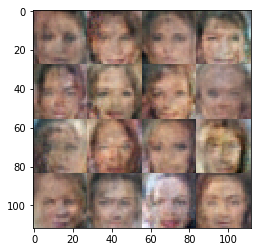

Epoch 2/10... Discriminator Loss: 1.3314... Generator Loss: 0.6909
Epoch 2/10... Discriminator Loss: 1.2939... Generator Loss: 1.2784
Epoch 2/10... Discriminator Loss: 1.2166... Generator Loss: 1.2809
Epoch 2/10... Discriminator Loss: 1.2890... Generator Loss: 0.9044
Epoch 2/10... Discriminator Loss: 1.3348... Generator Loss: 0.8661
Epoch 2/10... Discriminator Loss: 1.0464... Generator Loss: 1.1953
Epoch 2/10... Discriminator Loss: 1.1675... Generator Loss: 1.0713
Epoch 2/10... Discriminator Loss: 1.3338... Generator Loss: 1.3719
Epoch 2/10... Discriminator Loss: 1.1909... Generator Loss: 1.0571
Epoch 2/10... Discriminator Loss: 1.2375... Generator Loss: 1.1656


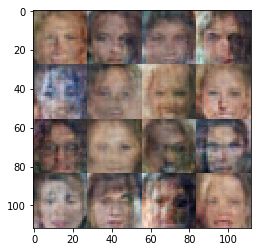

Epoch 2/10... Discriminator Loss: 1.4077... Generator Loss: 0.8108
Epoch 2/10... Discriminator Loss: 1.3119... Generator Loss: 0.7165
Epoch 2/10... Discriminator Loss: 1.1442... Generator Loss: 1.2003
Epoch 2/10... Discriminator Loss: 1.3076... Generator Loss: 1.0036
Epoch 2/10... Discriminator Loss: 1.0959... Generator Loss: 1.2665
Epoch 2/10... Discriminator Loss: 1.5575... Generator Loss: 1.6153
Epoch 2/10... Discriminator Loss: 1.1922... Generator Loss: 1.2046
Epoch 2/10... Discriminator Loss: 1.1004... Generator Loss: 1.0213
Epoch 2/10... Discriminator Loss: 1.3792... Generator Loss: 0.8099
Epoch 2/10... Discriminator Loss: 1.1672... Generator Loss: 0.9538


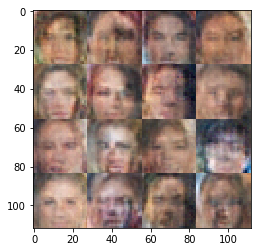

Epoch 2/10... Discriminator Loss: 1.2297... Generator Loss: 0.9320
Epoch 2/10... Discriminator Loss: 1.1802... Generator Loss: 0.9846
Epoch 2/10... Discriminator Loss: 1.1672... Generator Loss: 1.2295
Epoch 2/10... Discriminator Loss: 1.3460... Generator Loss: 1.4258
Epoch 2/10... Discriminator Loss: 1.3315... Generator Loss: 1.2761
Epoch 2/10... Discriminator Loss: 1.1860... Generator Loss: 1.0886
Epoch 2/10... Discriminator Loss: 1.2975... Generator Loss: 0.7467
Epoch 2/10... Discriminator Loss: 1.1557... Generator Loss: 1.1614
Epoch 2/10... Discriminator Loss: 1.1770... Generator Loss: 1.2541
Epoch 2/10... Discriminator Loss: 1.1139... Generator Loss: 0.9287


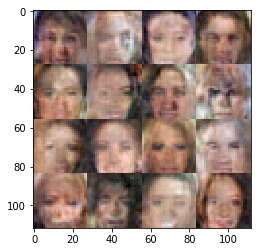

Epoch 2/10... Discriminator Loss: 1.4336... Generator Loss: 1.6756
Epoch 2/10... Discriminator Loss: 1.1133... Generator Loss: 1.0998
Epoch 2/10... Discriminator Loss: 1.1262... Generator Loss: 1.1317
Epoch 2/10... Discriminator Loss: 1.4627... Generator Loss: 0.5161
Epoch 2/10... Discriminator Loss: 1.1946... Generator Loss: 0.7629
Epoch 2/10... Discriminator Loss: 1.0670... Generator Loss: 1.4110
Epoch 2/10... Discriminator Loss: 1.4962... Generator Loss: 1.3892
Epoch 2/10... Discriminator Loss: 1.2563... Generator Loss: 1.3787
Epoch 2/10... Discriminator Loss: 1.4986... Generator Loss: 0.5018
Epoch 2/10... Discriminator Loss: 1.2320... Generator Loss: 1.1199


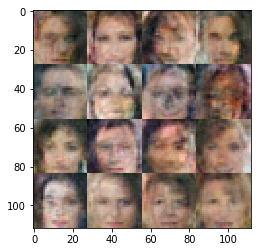

Epoch 2/10... Discriminator Loss: 1.2192... Generator Loss: 1.1428
Epoch 2/10... Discriminator Loss: 1.1739... Generator Loss: 1.1851
Epoch 2/10... Discriminator Loss: 1.1820... Generator Loss: 0.9386
Epoch 2/10... Discriminator Loss: 1.2461... Generator Loss: 1.0241
Epoch 2/10... Discriminator Loss: 1.2081... Generator Loss: 1.6117
Epoch 2/10... Discriminator Loss: 2.3150... Generator Loss: 2.9094
Epoch 2/10... Discriminator Loss: 1.1998... Generator Loss: 0.9596
Epoch 2/10... Discriminator Loss: 1.1921... Generator Loss: 0.8414
Epoch 2/10... Discriminator Loss: 1.3089... Generator Loss: 1.5595
Epoch 2/10... Discriminator Loss: 1.3919... Generator Loss: 0.9052


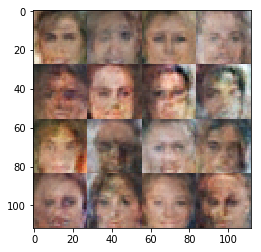

Epoch 2/10... Discriminator Loss: 1.3349... Generator Loss: 0.6307
Epoch 2/10... Discriminator Loss: 1.0794... Generator Loss: 1.0912
Epoch 2/10... Discriminator Loss: 1.2216... Generator Loss: 1.1715
Epoch 2/10... Discriminator Loss: 1.2780... Generator Loss: 0.7643
Epoch 2/10... Discriminator Loss: 1.2238... Generator Loss: 0.7333
Epoch 2/10... Discriminator Loss: 0.9880... Generator Loss: 3.5098
Epoch 2/10... Discriminator Loss: 1.8460... Generator Loss: 1.1441
Epoch 2/10... Discriminator Loss: 1.1248... Generator Loss: 0.8628
Epoch 2/10... Discriminator Loss: 1.1604... Generator Loss: 1.5129
Epoch 2/10... Discriminator Loss: 1.3657... Generator Loss: 1.8412


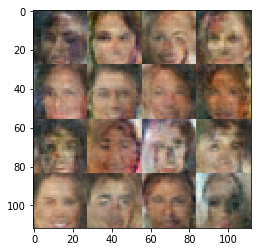

Epoch 2/10... Discriminator Loss: 1.1705... Generator Loss: 1.0715
Epoch 2/10... Discriminator Loss: 1.1734... Generator Loss: 0.9529
Epoch 2/10... Discriminator Loss: 1.4959... Generator Loss: 0.4620
Epoch 2/10... Discriminator Loss: 1.1343... Generator Loss: 1.4247
Epoch 2/10... Discriminator Loss: 1.2754... Generator Loss: 0.9683
Epoch 2/10... Discriminator Loss: 1.2302... Generator Loss: 0.7365
Epoch 2/10... Discriminator Loss: 1.2732... Generator Loss: 0.7446
Epoch 2/10... Discriminator Loss: 1.1432... Generator Loss: 1.0806
Epoch 2/10... Discriminator Loss: 1.2060... Generator Loss: 1.1350
Epoch 2/10... Discriminator Loss: 1.1913... Generator Loss: 0.8851


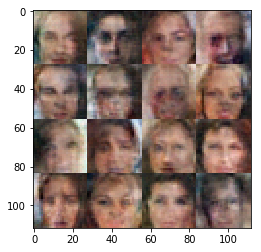

Epoch 2/10... Discriminator Loss: 1.2392... Generator Loss: 1.1675
Epoch 2/10... Discriminator Loss: 1.2806... Generator Loss: 1.3211
Epoch 2/10... Discriminator Loss: 1.2835... Generator Loss: 1.7100
Epoch 2/10... Discriminator Loss: 1.7660... Generator Loss: 0.3340
Epoch 2/10... Discriminator Loss: 1.4070... Generator Loss: 0.5359
Epoch 2/10... Discriminator Loss: 1.1366... Generator Loss: 1.3636
Epoch 3/10... Discriminator Loss: 1.2391... Generator Loss: 0.7758
Epoch 3/10... Discriminator Loss: 1.1449... Generator Loss: 0.9388
Epoch 3/10... Discriminator Loss: 1.2445... Generator Loss: 0.8168
Epoch 3/10... Discriminator Loss: 1.2795... Generator Loss: 0.6502


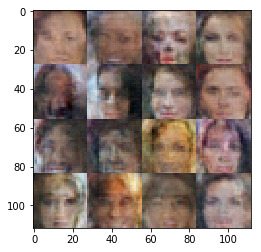

Epoch 3/10... Discriminator Loss: 1.2738... Generator Loss: 0.8338
Epoch 3/10... Discriminator Loss: 1.3293... Generator Loss: 1.5450
Epoch 3/10... Discriminator Loss: 1.2235... Generator Loss: 1.4125
Epoch 3/10... Discriminator Loss: 1.2802... Generator Loss: 0.6881
Epoch 3/10... Discriminator Loss: 1.0252... Generator Loss: 1.0848
Epoch 3/10... Discriminator Loss: 1.7438... Generator Loss: 0.3474
Epoch 3/10... Discriminator Loss: 1.1167... Generator Loss: 0.9228
Epoch 3/10... Discriminator Loss: 1.0194... Generator Loss: 1.0203
Epoch 3/10... Discriminator Loss: 1.0067... Generator Loss: 2.5132
Epoch 3/10... Discriminator Loss: 1.4684... Generator Loss: 0.4939


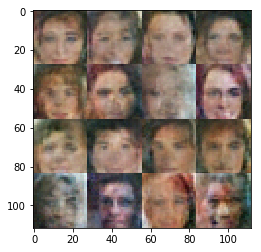

Epoch 3/10... Discriminator Loss: 0.9642... Generator Loss: 1.2527
Epoch 3/10... Discriminator Loss: 1.1785... Generator Loss: 1.0657
Epoch 3/10... Discriminator Loss: 1.1691... Generator Loss: 1.0015
Epoch 3/10... Discriminator Loss: 1.1441... Generator Loss: 1.1842
Epoch 3/10... Discriminator Loss: 1.1409... Generator Loss: 1.1579
Epoch 3/10... Discriminator Loss: 1.1779... Generator Loss: 1.2888
Epoch 3/10... Discriminator Loss: 1.3817... Generator Loss: 1.4126
Epoch 3/10... Discriminator Loss: 1.0102... Generator Loss: 1.0624
Epoch 3/10... Discriminator Loss: 1.4714... Generator Loss: 0.6126
Epoch 3/10... Discriminator Loss: 1.3460... Generator Loss: 0.6250


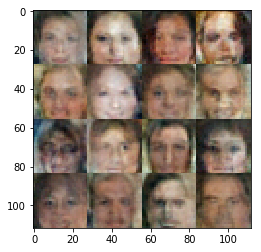

Epoch 3/10... Discriminator Loss: 1.1354... Generator Loss: 1.1006
Epoch 3/10... Discriminator Loss: 1.7813... Generator Loss: 1.8629
Epoch 3/10... Discriminator Loss: 1.1729... Generator Loss: 0.8729
Epoch 3/10... Discriminator Loss: 1.0809... Generator Loss: 1.6476
Epoch 3/10... Discriminator Loss: 1.3914... Generator Loss: 1.2093
Epoch 3/10... Discriminator Loss: 1.3312... Generator Loss: 0.6037
Epoch 3/10... Discriminator Loss: 1.2441... Generator Loss: 2.0325
Epoch 3/10... Discriminator Loss: 1.7516... Generator Loss: 0.4792
Epoch 3/10... Discriminator Loss: 1.0528... Generator Loss: 1.1488
Epoch 3/10... Discriminator Loss: 1.1404... Generator Loss: 1.0299


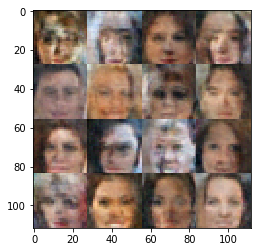

Epoch 3/10... Discriminator Loss: 1.1574... Generator Loss: 1.1674
Epoch 3/10... Discriminator Loss: 0.8216... Generator Loss: 1.9734
Epoch 3/10... Discriminator Loss: 1.3402... Generator Loss: 0.6942
Epoch 3/10... Discriminator Loss: 1.3652... Generator Loss: 0.7000
Epoch 3/10... Discriminator Loss: 1.0977... Generator Loss: 1.3353
Epoch 3/10... Discriminator Loss: 1.2993... Generator Loss: 0.8907
Epoch 3/10... Discriminator Loss: 1.1044... Generator Loss: 0.8688
Epoch 3/10... Discriminator Loss: 1.4775... Generator Loss: 2.3914
Epoch 3/10... Discriminator Loss: 1.2312... Generator Loss: 0.8847
Epoch 3/10... Discriminator Loss: 1.2289... Generator Loss: 1.2749


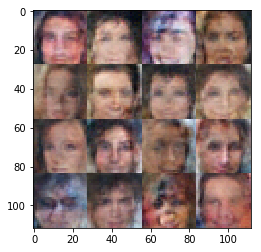

Epoch 3/10... Discriminator Loss: 1.0457... Generator Loss: 0.9385
Epoch 3/10... Discriminator Loss: 1.1306... Generator Loss: 0.7853
Epoch 3/10... Discriminator Loss: 1.0834... Generator Loss: 0.8642
Epoch 3/10... Discriminator Loss: 1.2145... Generator Loss: 1.0754
Epoch 3/10... Discriminator Loss: 1.4355... Generator Loss: 0.5332
Epoch 3/10... Discriminator Loss: 1.5091... Generator Loss: 0.5427


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.01
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.